In [89]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

from utils import *

import seaborn as sns
from matplotlib import rcParams
from cycler import cycler

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [90]:

class AnalyseDefects:
    def __init__(self, input_list, output_path = 'data'):
        """"
        input_list: list of dictionaries. Each dictionary contains the following keys:
        "path": path to the defect folder
        "suffix": suffix of the defect folder
        "priority": int: defect priority. The higher the more important and will overwrite the lower priority results
        "LX": int: system size in x direction
        "Nframes": int: number of frames in the defect folder

        """
        self.Ndata = len(input_list)
        self.input_list = input_list
        self.input_paths = [input["path"] for input in input_list]
        self.suffixes = [input["suffix"] for input in input_list]
        self.priorities = [input["priority"] for input in input_list]
        self.LX = [int(input["LX"]) for input in input_list]
        self.Nframes = [int(input["Nframes"]) for input in input_list]

        self.output_main_path = output_path 
        self.output_paths = [os.path.join(self.output_main_path, self.suffixes[i]) for i in range(self.Ndata)]
        self.Nexp = []
        self.Nactivity = []
        self.act_list = []
        self.act_dir_list = []
        self.window_sizes = []
        self.conv_list = []
        
        self.Ndata = len(input_list)

        
        for i, input in enumerate(self.input_paths):
            Nsubdir = 1
            act = []
            act_dir = []
            self.Nactivity.append(len(os.listdir(input)))
            for j, subdir in enumerate(os.listdir(input)):
        
                subdir_full = os.path.join(input, subdir)
                act.append(np.round(float(subdir_full.split('_')[-1]),4))
                act_dir.append(subdir_full)
                Nsubdir = max(Nsubdir, len(os.listdir(os.path.join(input, subdir))))

                if j == 0:
                    subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
                    dir_windows = os.path.join(subsubdir, 'window_sizes.txt')
                    windows = np.loadtxt(dir_windows)
                    self.window_sizes.append(windows)

                    if not os.path.isdir(self.output_paths[i]):
                        os.makedirs(self.output_paths[i])

                    # save the window sizes
                    np.savetxt(os.path.join(self.output_paths[i], 'window_sizes.txt'), windows)

            act, act_dir = zip(*sorted(zip(act, act_dir)))

            # save the activity list
            np.savetxt(os.path.join(self.output_paths[i], 'activity_list.txt'), act)

            self.act_list.append(act)
            self.act_dir_list.append(act_dir)
            self.Nexp.append(Nsubdir)

        for i, output in enumerate(self.output_paths):
            if not os.path.exists(output):
                os.makedirs(output)

            # load the convergence list if it exists
            try:
                self.conv_list.append(np.loadtxt(os.path.join(output, 'conv_list.txt').astype(int)))
            except:
                self.conv_list.append([0] * self.Nactivity[i])

    def __calc_binder(self, Ndataset = 0):

        defect_arr = self.get_arrays_full(Ndataset=Ndataset)[0]

        act_list = self.act_list[Ndataset]
        conv_list = self.conv_list[Ndataset]
        Nact = len(act_list)

        p4 = defect_arr ** 4
        p2 = defect_arr ** 2

        binder_cumulants = np.zeros([Nact, 2]) * np.nan
        p4_av = np.zeros(Nact)
        p2_av = np.zeros(Nact)
        p4_std = np.zeros(Nact)
        p2_std = np.zeros(Nact)

        for i, act in enumerate(act_list):
            Npoints = p4[conv_list[i]:,i,:].size
            p4_av[i] = np.nanmean(np.nanmean(p4[conv_list[i]:,i,:]))
            p2_av[i] = np.nanmean(np.nanmean(p2[conv_list[i]:,i,:]))
            p4_std[i] = np.nanstd(p4[conv_list[i]:,i,:]) / np.sqrt(Npoints)
            p2_std[i] = np.nanstd(p2[conv_list[i]:,i,:]) / np.sqrt(Npoints)
       
        binder_cumulants[:,0] = 1 - p4_av / (3 * p2_av ** 2)

        # find the error in the binder cumulant
        dzdx = lambda x, y: - 1 / (3 * y ** 2)
        dzdy = lambda x, y: 2 * x / (3 * y ** 3)

        correlation = calc_corr_matrix(np.array([p4_av, p2_av]).T)[0,1]
        binder_cumulants[:,1] = prop_err(dzdx, dzdy, p4_av, p2_av, p4_std, p2_std, correlation = correlation)

        return binder_cumulants

    def extract_results(self, save = True, normalize = True):
        """
        Analyse the defects for all the input folders
        """
        for N in range(self.Ndata):

            defect_arr = np.nan * np.zeros((self.Nframes[N], self.Nactivity[N], self.Nexp[N]))
            av_counts = np.nan * np.zeros([self.Nframes[N], len(self.window_sizes[N]), self.Nactivity[N], self.Nexp[N]])
            var_counts = np.nan * np.zeros_like(av_counts)
            
            print('Analyse defects for input folder {}'.format(self.input_paths[N]))
            for i, (act, act_dir) in enumerate(zip(self.act_list[N], self.act_dir_list[N])):
                exp_list = []
                exp_dir_list = []

                for file in os.listdir(act_dir):
                    exp_count = file.split('_')[-1]
                    exp_list.append(int(exp_count))
                    exp_dir_list.append(os.path.join(act_dir, file))

                # sort the activity list and the activity directory list
                exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

                for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
                    defect_arr[:, i, j] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[-self.Nframes[N]:]

                    counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                    vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]

                    idx_start_count = min(self.Nframes[N], len(counts))
                    av_counts[-idx_start_count:, :, i, j] = counts[-idx_start_count:, :]
                    var_counts[-idx_start_count:, :, i, j] = vars[-idx_start_count:, :]

            dens_fluc = var_counts / (np.pi * self.window_sizes[N][:, None, None] ** 2) ** 2
            if normalize:
                av_dens = defect_arr / self.LX[N] ** 2
                dens_fluc = dens_fluc / av_dens[:, None, :, :] ** 2

            if save:
                np.save(os.path.join(self.output_paths[N], 'defect_arr.npy'), defect_arr)
                np.save(os.path.join(self.output_paths[N], 'av_counts.npy'), av_counts)
                np.save(os.path.join(self.output_paths[N], 'var_counts.npy'), var_counts)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc.npy'), dens_fluc)

    def analyze_defects(self, Ndataset_list = None, save = True,):
        Ndataset_list = range(self.Ndata) if Ndataset_list is None else Ndataset_list

        for N in Ndataset_list:
            while True:
                try:
                    defect_arr = np.load(os.path.join(self.output_paths[N], 'defect_arr.npy'))
                    av_counts = np.load(os.path.join(self.output_paths[N], 'av_counts.npy'))
                    var_counts = np.load(os.path.join(self.output_paths[N], 'var_counts.npy'))
                    dens_fluc = np.load(os.path.join(self.output_paths[N], 'dens_fluc.npy'))
                    break
                except:
                    print('Defect array not found. They will be extracted now using normalize = True')
                    self.extract_results(save = True, normalize = True)

            if len(np.unique(self.conv_list[N])) == 1:
                print(f'NB: All simulations are set to converge at the first frame for dataset {N}. To change this, call update_conv_list.\n')

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                defect_arr_av = np.nanmean(defect_arr, axis = -1)
                defect_arr_std = np.nanstd(defect_arr, axis = -1) / np.sqrt(self.Nexp[N])
                av_counts_av = np.nanmean(av_counts, axis = -1)
                av_counts_std = np.nanstd(av_counts, axis = -1) / np.sqrt(self.Nexp[N])
                var_counts_av = np.nanmean(var_counts, axis = -1)
                var_counts_std = np.nanstd(var_counts, axis = -1) / np.sqrt(self.Nexp[N])
                dens_fluc_av = np.nanmean(dens_fluc, axis = -1)
                dens_fluc_std = np.nanstd(dens_fluc, axis = -1) / np.sqrt(self.Nexp[N])

            av_defects = np.zeros((self.Nactivity[N], 2))
            susceptibility = np.zeros((len(self.window_sizes[N]), self.Nactivity[N], 2)) * np.nan

            for i, act in enumerate(self.act_list[N]):
                av_defects[i, 0] = np.mean(defect_arr_av[self.conv_list[N][i]:, i])
                av_defects[i, 1] = np.mean(defect_arr_std[self.conv_list[N][i]:, i]) / np.sqrt(self.Nframes[N] - self.conv_list[N][i])
                susceptibility[:, i, 0] = np.nanmean(dens_fluc_av[self.conv_list[N][i]:, :, i], axis = 0)
                susceptibility[:, i, 1] = np.nanstd(dens_fluc_av[self.conv_list[N][i]:, :, i], axis = 0) / np.sqrt(self.Nframes[N] - self.conv_list[N][i])
       
            susceptibility[:, :, 0] *= av_defects[:, 0][None, :]
            susceptibility[:, :, 1] *= av_defects[:, 0][None, :]

            binder_cumulants = self.__calc_binder(Ndataset = N)
 
            if save:
                np.save(os.path.join(self.output_paths[N], 'defect_arr_av.npy'), defect_arr_av)
                np.save(os.path.join(self.output_paths[N], 'defect_arr_std.npy'), defect_arr_std)
                np.save(os.path.join(self.output_paths[N], 'av_counts_av.npy'), av_counts_av)
                np.save(os.path.join(self.output_paths[N], 'av_counts_std.npy'), av_counts_std)
                np.save(os.path.join(self.output_paths[N], 'var_counts_av.npy'), var_counts_av)
                np.save(os.path.join(self.output_paths[N], 'var_counts_std.npy'), var_counts_std)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'), dens_fluc_av)
                np.save(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'), dens_fluc_std)
                np.save(os.path.join(self.output_paths[N], 'av_defects.npy'), av_defects)
                np.save(os.path.join(self.output_paths[N], 'susceptibility.npy'), susceptibility)
                np.save(os.path.join(self.output_paths[N], 'binder_cumulants.npy'), binder_cumulants)
        return

    def merge_results(self, save_path = None, save = True):

        if save_path is None:
            save_path = os.path.join(self.output_main_path, 'merged_results')
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        Nbase = np.argmin(self.priorities)
        Nbase_frames = self.Nframes[Nbase]
        window_sizes = self.window_sizes[Nbase]

        try:
            # load the results from the base dataset
            defect_arr_av = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_av.npy'))
            defect_arr_std = np.load(os.path.join(self.output_paths[Nbase], 'defect_arr_std.npy'))
            av_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_av.npy'))  
            av_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'av_counts_std.npy'))
            var_counts_av = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_av.npy'))
            var_counts_std = np.load(os.path.join(self.output_paths[Nbase], 'var_counts_std.npy'))
            dens_fluc_av = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_av.npy'))
            dens_fluc_std = np.load(os.path.join(self.output_paths[Nbase], 'dens_fluc_std.npy'))
            av_defects = np.load(os.path.join(self.output_paths[Nbase], 'av_defects.npy'))
            susceptibility = np.load(os.path.join(self.output_paths[Nbase], 'susceptibility.npy'))
            binder_cumulants = np.load(os.path.join(self.output_paths[Nbase], 'binder_cumulants.npy'))
        except:
            print('Base dataset not found. Analyse defects first.')
            return

        # overwrite the activities with the ones from the other datasets according to self.priorities
        _, Nsorted = zip(*sorted(zip(self.priorities, range(self.Ndata))))

        for N in Nsorted[1:]:
           # act_min, act_max = self.act_list[N][0], self.act_list[N][-1]
            #act_min_idx = self.act_list[Nbase].index(act_min)
            #act_max_idx = self.act_list[Nbase].index(act_max) + 1
           # act_list = self.act_list[N]
            act_idx_list = []
            for act in self.act_list[N]:
                act_idx_list.append(self.act_list[Nbase].index(act))

            defect_arr_av[:, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'defect_arr_av.npy'))[-Nbase_frames:]
            defect_arr_std[:, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'defect_arr_std.npy'))[-Nbase_frames:]

            var_counts_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'var_counts_av.npy'))[-Nbase_frames:]
            var_counts_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'var_counts_std.npy'))[-Nbase_frames:]

            dens_fluc_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_av.npy'))[-Nbase_frames:]
            dens_fluc_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'dens_fluc_std.npy'))[-Nbase_frames:]

            av_counts_av[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_counts_av.npy'))[-Nbase_frames:]
            av_counts_std[:, :, act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_counts_std.npy'))[-Nbase_frames:]

            av_defects[act_idx_list] = np.load(os.path.join(self.output_paths[N], 'av_defects.npy'))
            susceptibility[:, act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'susceptibility.npy'))
            binder_cumulants[act_idx_list, :] = np.load(os.path.join(self.output_paths[N], 'binder_cumulants.npy'))
            
        if save:
            np.save(os.path.join(save_path, 'activity_list.npy'), self.act_list[Nbase])
            np.save(os.path.join(save_path, 'window_sizes.npy'), window_sizes)
            np.save(os.path.join(save_path, 'defect_arr_av.npy'), defect_arr_av)
            np.save(os.path.join(save_path, 'defect_arr_std.npy'), defect_arr_std)
            np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
            np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
            np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
            np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
            np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
            np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
            np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
            np.save(os.path.join(save_path, 'susceptibility.npy'), susceptibility)
            np.save(os.path.join(save_path, 'binder_cumulants.npy'), binder_cumulants)
        return
    
    def analyze_hyperuniformity(self, Ndataset = 0, fit_densities = False, fit_dict = {}, window_idx_bounds = None, \
                                act_idx_bounds = None, use_merged = False, save = True, plot = True):
        
        suffix = 'dens' if fit_densities else 'count'

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
        if fit_densities:
            try:
                var_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            except:
                print('Density fluctuations not found. Analyse defects first.')
                return
        else:
            try:
                var_av = np.load(os.path.join(output_path, 'var_counts_av.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
                var_std = np.load(os.path.join(output_path, 'var_counts_std.npy'))[:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            except:
                print('Variance of counts not found. Analyse defects first.')
                return

        if fit_dict == {}:
            if fit_densities:
                def fit_func(x, alpha, beta):
                    return beta * (- 2 - alpha) + (- 2 - alpha) * x
                param_guess = np.array([-0.1, 10])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
            else:
                def fit_func(x, alpha, beta):
                    return beta * (2 - alpha) + (2 - alpha) * x
                param_guess = np.array([0.1, 0.3])
                fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
        else:
            fit_func = fit_dict['fit_func']
            param_guess = fit_dict['param_guess']
            fit_string = fit_dict['fit_string']

        Nparams = len(param_guess)
            
        fit_params = np.zeros([self.Nframes[Ndataset], len(act_list), 2 * Nparams]) * np.nan
        stat_arr = np.zeros([self.Nframes[Ndataset], len(act_list), 3]) * np.nan
        alpha_list = np.zeros([len(act_list), 2]) * np.nan

        for i, act in enumerate(act_list):
            for frame in range(self.conv_list[Ndataset][i], self.Nframes[Ndataset]):
                count_var_av = var_av[frame, :, i]
                count_var_std = var_std[frame, :, i]
                zero_mask = (count_var_av > 0) & (count_var_std > 0)

                if len(count_var_av[zero_mask]) < 10:
                    continue
                try:
                    x = np.log(window_sizes[zero_mask])
                    y = np.log(count_var_av[zero_mask])
                    yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
                except:
                    continue
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
                    fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

                stat_arr[frame, i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
                fit_params[frame, i, :Nparams] = fit.values[:]
                fit_params[frame, i, Nparams:] = fit.errors[:]

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    alpha_mean, alpha_err = calc_weighted_mean_vec(fit_params[self.conv_list[Ndataset][i]:, i, 0], fit_params[self.conv_list[Ndataset][i]:, i, Nparams])[:2]
            except:
                alpha_mean, alpha_err = np.nan, np.nan

            alpha_list[i] = alpha_mean, alpha_err

        print("Non-converged fits (p < 0.05): ", np.nansum((stat_arr[:, :, -1] < 0.05)))

        if save:
            np.save(os.path.join(output_path, f'fit_params_{suffix}.npy'), fit_params)
            np.save(os.path.join(output_path, f'stat_arr_{suffix}.npy'), stat_arr)
            np.save(os.path.join(output_path, f'alpha_list_{suffix}.npy'), alpha_list)
            np.save(os.path.join(output_path, f'act_list_alpha_fit.npy'), act_list)
        if plot:
            self.plot_hyperuniformity_exp_all(fit_params = fit_params, stat_arr = stat_arr, Ndataset = Ndataset, \
                                              act_idx_bounds = act_idx_bounds, use_merged = use_merged)
        return fit_params, stat_arr

    def get_arrays_full(self, Ndataset = 0,):
        """
        returns defect_arr, var_counts, dens_fluc, av_counts
        """
        output_path = self.output_paths[Ndataset]
        try:
            defect_arr = np.load(os.path.join(output_path, 'defect_arr.npy'))  
            var_counts = np.load(os.path.join(output_path, 'var_counts.npy'))
            dens_fluc = np.load(os.path.join(output_path, 'dens_fluc.npy'))
            av_counts = np.load(os.path.join(output_path, 'av_counts.npy'))
        except:
            print('Arrays not found. Analyse defects first.')
            return
        return defect_arr, var_counts, dens_fluc, av_counts
      
    def get_arrays_av(self, Ndataset = 0, return_av_counts = False, use_merged = False):
        """
        if return_av_counts:
        returns defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_counts_av, av_counts_std, av_defects
        else:
        returns defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_defects
        """


        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]
        try:
            defect_arr_av = np.load(os.path.join(output_path, 'defect_arr_av.npy'))
            defect_arr_std = np.load(os.path.join(output_path, 'defect_arr_std.npy'))
            var_counts_av = np.load(os.path.join(output_path, 'var_counts_av.npy'))
            var_counts_std = np.load(os.path.join(output_path, 'var_counts_std.npy'))
            dens_fluc_av = np.load(os.path.join(output_path, 'dens_fluc_av.npy'))
            dens_fluc_std = np.load(os.path.join(output_path, 'dens_fluc_std.npy'))
            av_counts_av = np.load(os.path.join(output_path, 'av_counts_av.npy'))
            av_counts_std = np.load(os.path.join(output_path, 'av_counts_std.npy'))
            av_defects = np.load(os.path.join(output_path, 'av_defects.npy'))
        except:
            print('Arrays not found. Analyse defects first.')
            return
        if return_av_counts:
            return defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_counts_av, av_counts_std, av_defects
        else:
            return defect_arr_av, defect_arr_std, var_counts_av, var_counts_std, dens_fluc_av, dens_fluc_std, av_defects

    def get_binder_susceptibility(self, Ndataset = 0, use_merged = False):
        """
        returns binder_cumulants, susceptibility
        """
        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]
        try:
            binder_cumulants = np.load(os.path.join(output_path, 'binder_cumulants.npy'))
            susceptibility = np.load(os.path.join(output_path, 'susceptibility.npy'))
        except:
            print('Binder cumulants or susceptibilitites not found. Analyse defects first.')
            return
        return binder_cumulants, susceptibility

    def update_conv_list(self, Ndataset_list = None):
        if Ndataset_list is None:
            Ndataset_list = range(self.Ndata)
        
        for i in Ndataset_list:
            fig, ax = self.plot_defects_per_activity(Ndataset = i, act_min_idx = 0, act_max_idx = None, plot_density = False)
            
            for j in range(self.Nactivity[i]):
                self.conv_list[i][j] = int(input(f'Enter the first frame to use for activity {self.act_list[i][j]}: '))

            # save the convergence list
            np.savetxt(os.path.join(self.output_paths[i], 'conv_list.txt'), self.conv_list[i])
        return

    def plot_av_defects(self, Ndataset = 0, fit_dict = {}, plot_density = True, verbose = False, use_merged = False):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'lower_act_index': index of the activity list to start the fit
        'param_guess': guess for the fit parameters
        """

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            lower_act_index = fit_dict['lower_act_index']
            param_guess = fit_dict['param_guess']

        norm = self.LX[Ndataset] ** 2 if plot_density else 1

        try:
            av_defects = np.load(os.path.join(output_path, 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return
        print(av_defects)
        fig, ax = plt.subplots(figsize=(9, 6))
        ax.errorbar(self.act_list[Ndataset], av_defects[:, 0], yerr = av_defects[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
        
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')

        if do_fit:
            activities = np.array(self.act_list[Ndataset][lower_act_index:])
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                fit = do_chi2_fit(fit_func, activities, av_defects[lower_act_index:, 0], \
                              av_defects[lower_act_index:, 1], parameter_guesses = param_guess, verbose=verbose)
                d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                text = nice_string_output(d, extra_spacing=4, decimals=3)
                add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

            ax.plot(activities, fit_func(activities, *fit.values[:]), 'r--', label=rf'Fit: {fit_string}')
            ax.legend(loc='lower right')

        fig.tight_layout()
        return fig, ax
        
    def plot_defects_per_activity(self, Ndataset = 0, Nfirst_frame = 0, act_min_idx = None, act_max_idx = None, plot_density = False, use_merged = False):
        
        if use_merged: 
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        act_min_idx = 0 if act_min_idx is None else act_min_idx
        activities = self.act_list[Ndataset][act_min_idx:act_max_idx] 
        norm = self.LX[Ndataset] ** 2 if plot_density else 1
        Nframes = self.Nframes[Ndataset] - Nfirst_frame

        try:
            defect_arr_av = np.load(os.path.join(output_path, 'defect_arr_av.npy'))[-Nframes:] / norm
            defect_arr_std = np.load(os.path.join(output_path, 'defect_arr_std.npy'))[-Nframes:] / norm
        except:
            print('Defect array not found. Analyse defects first.')
            return

        ncols = 4
        nrows = int(np.ceil(len(activities) / ncols))
        title = 'Defect density' if plot_density else 'Defect count'
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(activities):
            ax[i].errorbar(np.arange(Nframes), defect_arr_av[:, i], defect_arr_std[:, i], fmt='.', \
                            alpha = 0.15, markersize=9, label='Activity = {}'.format(act),)
            ax[i].legend()  

            # plot vertical lines to indicate the start of the averaging
            x=self.conv_list[Ndataset][i + act_min_idx] - Nfirst_frame
            if x > 0:
                ax[i].axvline(x=self.conv_list[Ndataset][i + act_min_idx], color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim(0, np.max(defect_arr_av[:, i]) * 1.8)

        fig.suptitle(f'{title} for different activities' , fontsize=22, y = 1)
        fig.supxlabel('Frame', fontsize=20, y = 0)
        fig.supylabel(f'{title}', fontsize=20, x=0)
        fig.tight_layout()
        plt.show()
        return fig, ax
    
    def plot_defects_per_exp(self, Ndataset = 0, act_min_idx = None, act_max_idx = None, plot_density = False):

        try:
            act_min_idx = 0 if act_min_idx is None else act_min_idx
            activities = self.act_list[Ndataset][act_min_idx:act_max_idx]
            norm = self.LX[Ndataset] ** 2 if plot_density else 1

            try:
                defect_arr = np.load(os.path.join(self.output_paths[Ndataset], 'defect_arr.npy'))
            except:
                print('Defect array not found. Analyse defects first.')
                return

            ncols = 4
            nrows = int(np.ceil(self.Nexp[Ndataset] / ncols))
            norm = self.LX[Ndataset] ** 2 if plot_density else 1
            title = 'Defect density' if plot_density else 'Defect count'

            for i, act in enumerate(activities):
                fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(22,13))
                ax = ax.flatten()  
                defect_arr_act = (defect_arr[:, i, :] / norm).astype(float)
                mini, maxi = np.nanmin(defect_arr_act) * 0.3, np.nanmax(defect_arr_act) * 1.5

                for j in np.arange(self.Nexp[Ndataset]):
                    ax[j].plot(np.arange(self.Nframes[Ndataset]), defect_arr_act[:, j], '.', label='Exp = {}'.format(j), alpha = 0.5)
                    ax[j].legend()  

                    ax[j].set_ylim(0, maxi)

                fig.suptitle(f'{title} for activity = {act}' , fontsize=18)
                fig.supxlabel('Frame', fontsize=18)
                fig.supylabel(f'{title}', fontsize=18)
                fig.tight_layout()
                plt.show()
        except:
            raise KeyboardInterrupt

    def plot_hyperuniformity_exp_all(self, fit_params = None, stat_arr = None, Ndataset = 0, act_idx_bounds = None, use_merged = False):

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]

        if isinstance(fit_params, np.ndarray) and isinstance(stat_arr, np.ndarray):
            pass
        else:
            fit_params = np.load(os.path.join(output_path, 'fit_params.npy'))
            stat_arr = np.load(os.path.join(output_path, 'stat_arr.npy'))

        if not len(act_list) == fit_params.shape[1]:
            print('The number of activities does not match the number of activities in the fit_params array.')
            return
        
        Nframes = fit_params.shape[0]
        Nparams = int(fit_params.shape[-1] / 2)
        Ngroup = 5

        ncols = 4
        nrows = int(np.ceil(len(act_list) / ncols))
        height = nrows * 4
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,height))
        ax = ax.flatten()  

        for i, act in enumerate(act_list):
            if i == 0:
                label1 = rf'$\chi^2$ fit p-value > 0.05'
                label2 = rf'$\chi^2$ fit p-value < 0.05'
                label3 = 'Weighted mean'
                label4 = 'Grouped mean'
            else:
                label1 = None
                label2 = None
                label3 = None
                label4 = None

            p_mask = stat_arr[self.conv_list[Ndataset][i]:, i, 2] > 0.05
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[p_mask], \
                        fit_params[self.conv_list[Ndataset][i]:,i,0][p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][p_mask], \
                            fmt='.', \
                        alpha = 0.3, markersize=2, label = label1)
            
            ax[i].errorbar(np.arange(self.conv_list[Ndataset][i], Nframes)[~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,0][~p_mask], \
                            fit_params[self.conv_list[Ndataset][i]:,i,Nparams][~p_mask], \
                                fmt='r.', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

            x = fit_params[self.conv_list[Ndataset][i]:, i, 0]
            max_idx = len(x) - len(x) % Ngroup 

            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                x_group = np.nanmean(x[:max_idx].reshape(-1, Ngroup), axis=1)
                dx_group = np.nanstd(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
                x_frames = np.arange(self.conv_list[Ndataset][i], self.conv_list[Ndataset][i] + max_idx, Ngroup) + Ngroup / 2

                if len(x_group < 10) > 10:
                    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
                
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[self.conv_list[Ndataset][i]:, i, Nparams])
            
            ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
            ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')

        fig.suptitle('Hyperuniformity exponent for different activities', y=1.05)
        fig.supxlabel('Frame')
        fig.supylabel(rf'$\alpha$')
        fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.75, 1.02))

        plt.tight_layout()
        return fig, ax

    def plot_alpha_mean(self, Ndataset = 0, use_density_fit = False, use_merged = False):
            
            suffix = 'dens' if use_density_fit else 'count'

            if use_merged:
                output_path = os.path.join(self.output_main_path, 'merged_results')
                Ndataset = np.argmin(self.priorities)
    
                if not os.path.isdir(output_path):
                    print(f'Merged results not found. Run merge_results first.')
                    return
            else:
                output_path = self.output_paths[Ndataset]
    
            try:
                act_list = np.load(os.path.join(output_path, f'act_list_alpha_fit.npy'))
                alpha_list = np.load(os.path.join(output_path, f'alpha_list_{suffix}.npy'))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
    
            fig, ax = plt.subplots(figsize=(9, 6))
            ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = '.-', capsize=2, label = f'L = {self.LX[Ndataset]}', \
                        capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4,)
            
            ax.legend()
            ax.set_xlabel(r'$\zeta$')
            ax.set_ylabel(rf'$\langle\alpha \rangle$')
            ax.set_title(rf'Time av. of $\alpha $ vs activity')
    
            fig.tight_layout()
            return fig, ax

    def plot_susceptibility(self, Ndataset = 0, Nwindows_jump = 0, act_max = None, window_idx_bounds = None, act_idx_bounds = None, use_merged = False):

        if use_merged:
            output_path = os.path.join(self.output_main_path, 'merged_results')
            Ndataset = np.argmin(self.priorities)

            if not os.path.isdir(output_path):
                print(f'Merged results not found. Run merge_results first.')
                return
        else:
            output_path = self.output_paths[Ndataset]

        if window_idx_bounds is None:
            window_idx_bounds = [0, len(self.window_sizes[Ndataset])]
        if act_idx_bounds is None:
            act_idx_bounds = [0, len(self.act_list[Ndataset])]

        window_sizes = self.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
  
        try:
            xi = np.load(os.path.join(output_path, 'susceptibility.npy'))[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
        except:
            print('Susceptibilities not found. Analyse defects first.')
            return
        
        bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
        try:
            for i, act in enumerate(act_list):
                if bin_count[i] > 0:
                    print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[i]))
        except:
            pass

        act_max = act_list[np.argmax(bin_count)] if act_max is None else act_max
        act_max_idx = act_list.index(act_max)
        xi_normed = np.zeros((len(window_sizes), len(act_list), 2))

        fig, ax = plt.subplots(figsize=(9, 6))

        for j, window in enumerate(window_sizes):
                norm = xi[j, act_max_idx, 0]
                if Nwindows_jump > 0:
                    if j  % Nwindows_jump == 0:
                        ax.errorbar(act_list, xi[j,:, 0] / norm,\
                                        xi[j, :, 1] / norm, label=f'WS = {np.round(window / self.LX[Ndataset],3)}', fmt='.', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
                xi_normed[j, :, 0] = xi[j, :, 0] / norm
                xi_normed[j, :, 1] = xi[j, :, 1] / norm

        # plot average xi
        xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
        xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))
        ax.errorbar(act_list, xi_mean, xi_std, label='average', fmt='.-', \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(rf'$\chi  / \chi (\zeta = {act_list[act_max_idx]}) $')
        ax.set_xlim(np.min(act_list) - 0.01,np.max(act_list) + 0.011)
        ax.set_ylim(-0.1, xi_mean.max() + 0.5)
    
        ax.legend(loc='upper right', ncol=5, fontsize = 10,)
        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()
 
        return fig, ax

    def plot_binder_cumulants(self, Ndataset = 0, act_idx_bounds = None, plot_binder = False, use_merged = False):
            
            if use_merged:
                output_path = os.path.join(self.output_main_path, 'merged_results')
                Ndataset = np.argmin(self.priorities)
    
                if not os.path.isdir(output_path):
                    print(f'Merged results not found. Run merge_results first.')
                    return
            else:
                output_path = self.output_paths[Ndataset]
    
            if act_idx_bounds is None:
                act_idx_bounds = [0, len(self.act_list[Ndataset])]
    
            act_list = self.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]
    
            try:
                binder = np.load(os.path.join(output_path, 'binder_cumulants.npy'))[act_idx_bounds[0]:act_idx_bounds[1], :]
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
    
            fig, ax = plt.subplots(figsize=(9, 6))

            if plot_binder:
                y = binder[:, 0]
                ylabel = r'$U_B(\rho)$'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                

            else:
                y = 2/3 - binder[:, 0]
                ylabel = r'$U(\rho)$'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'

            ax.text(0.10, 0.95, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
            ax.errorbar(act_list, y, binder[:, 1], fmt='.-', label = rf'N = {self.LX[Ndataset]}', \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4,)

            ax.set_xlabel(r' $\zeta$ (activity)')
            ax.set_ylabel(ylabel)
            ax.legend(loc='upper right', ncol=2, fontsize = 18)
            fig.suptitle(title, fontsize=20)
            fig.tight_layout()
            return fig, ax

    
# EVT EN DENS FLUK PLOT



Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05_long
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05_very_long
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05_very_long_old
NB: All simulations are set to converge at the first frame for dataset 0. To change this, call update_conv_list.

NB: All simulations are set to converge at the first frame for dataset 1. To change this, call update_conv_list.

NB: All simulations are set to converge at the first frame for dataset 2. To change this, call update_conv_list.

NB: All simulations are set to converge at the first frame for dataset 3. To change this, call update_conv_list.



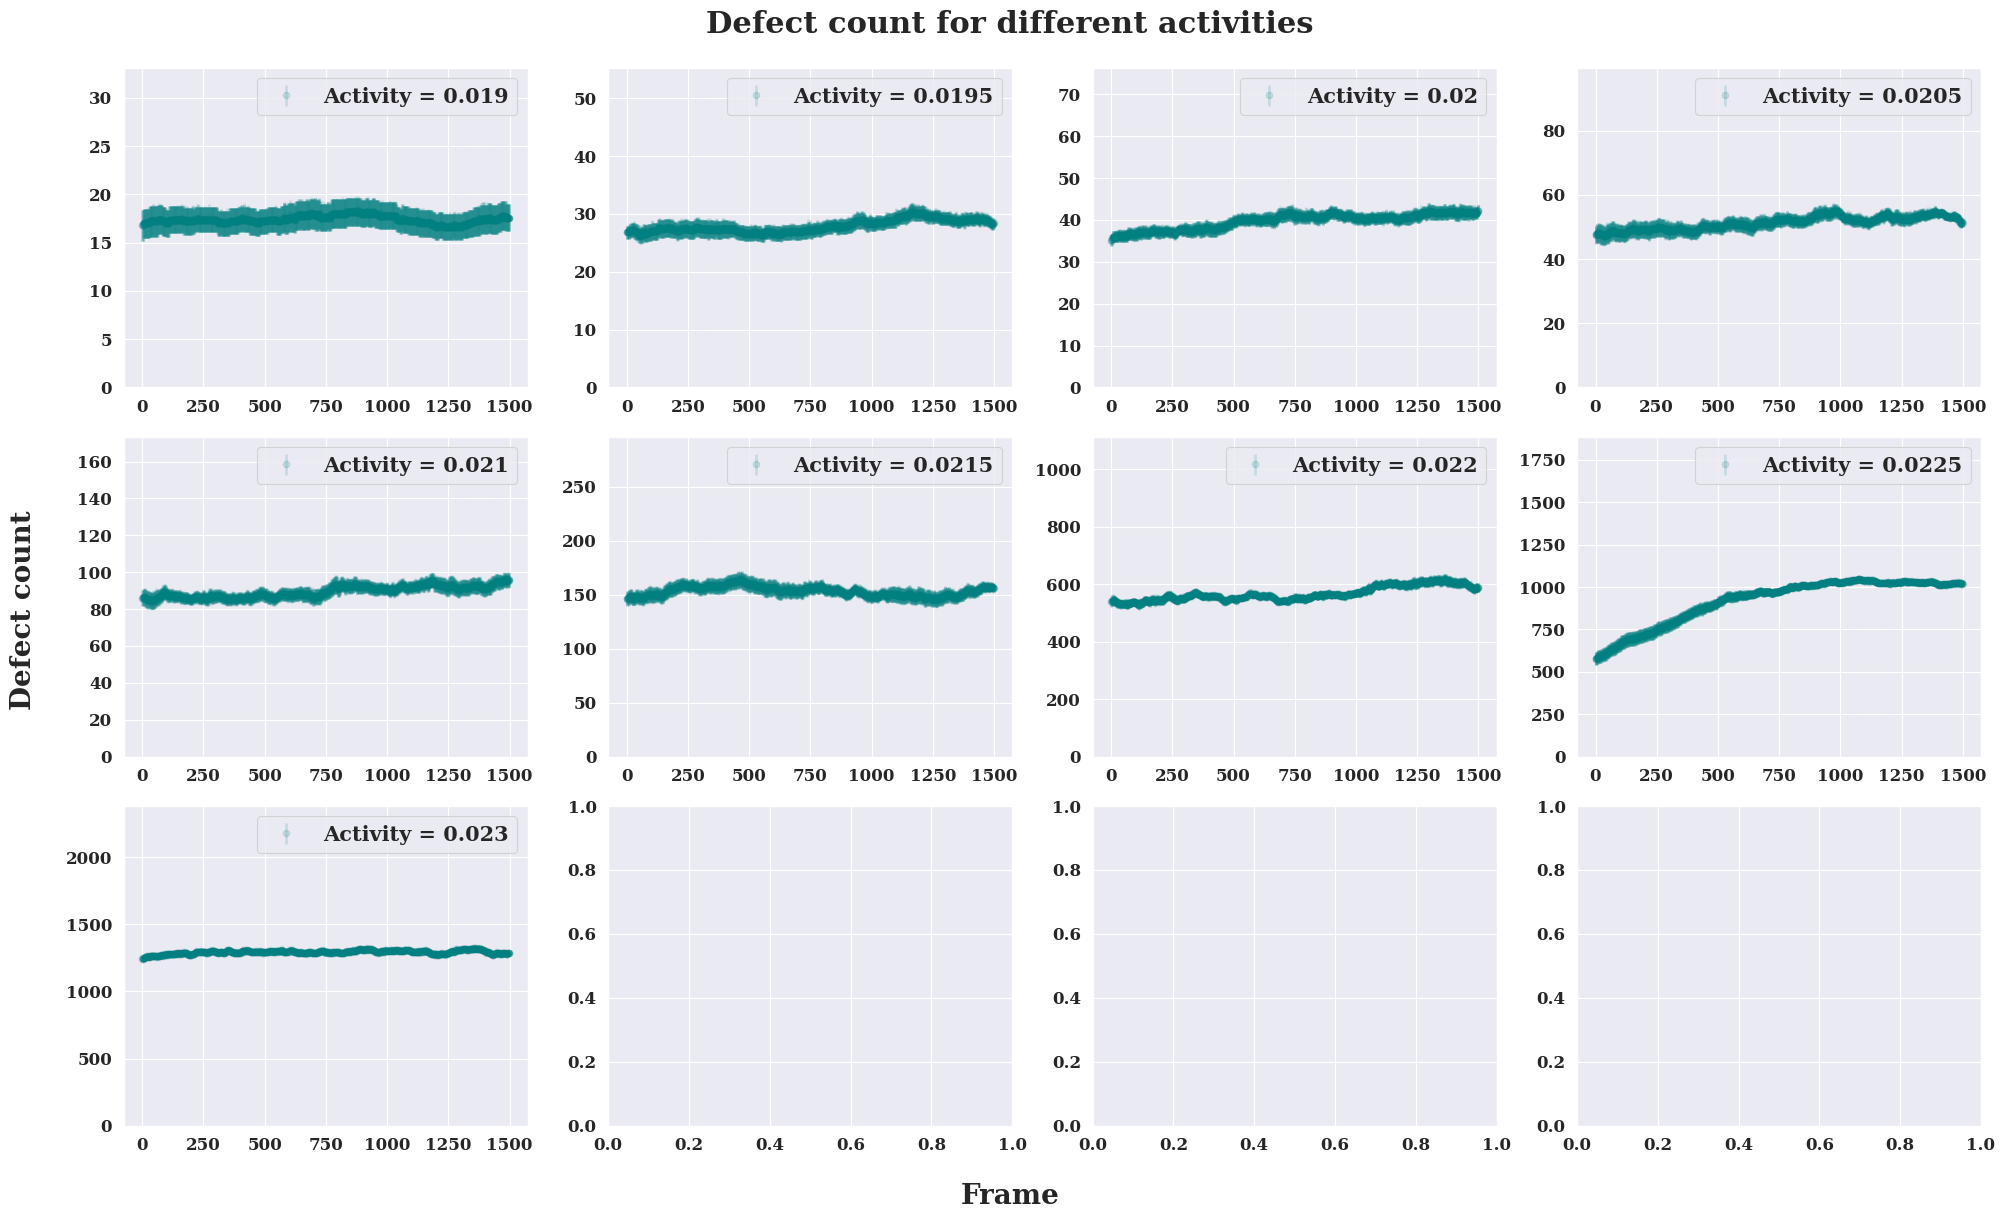

(<Figure size 2000x1200 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

In [93]:
LL = 1024
dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
             suffix = "long", priority = 0, LX = LL, Nframes = 400)
dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                   suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_old',\
                   suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)
defect_list = [dshort, dlong, dvery_long, dvery_long2]
#defect_list = [dshort, dlong]
#defect_list = [dshort]
output_path = f'data\\nematic_analysis{LL}_LL0.05'


def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
fit_string = rf'$y = a \ln x + bx + c $'
fit_dict = dict(fit_func = log_func, fit_string = fit_string, lower_act_index = 12, param_guess = np.array([0.005, 0.04,0.015]))

ad = AnalyseDefects(defect_list, output_path=output_path)
#ad.plot_defects_per_activity(Ndataset=2, use_merged=True)
ad.extract_results()
ad.analyze_defects()
ad.merge_results()
ad.plot_defects_per_activity(Ndataset=2, use_merged=False)

#fitp, statp = ad.analyze_hyperuniformity(fit_densities=True, save = True, \
   #                                      plot = True, use_merged = True,act_bounds=[7,-1], window_idx_bounds=[7, -3]);
#ad.plot_alpha_mean(use_density_fit=True, use_merged=True)

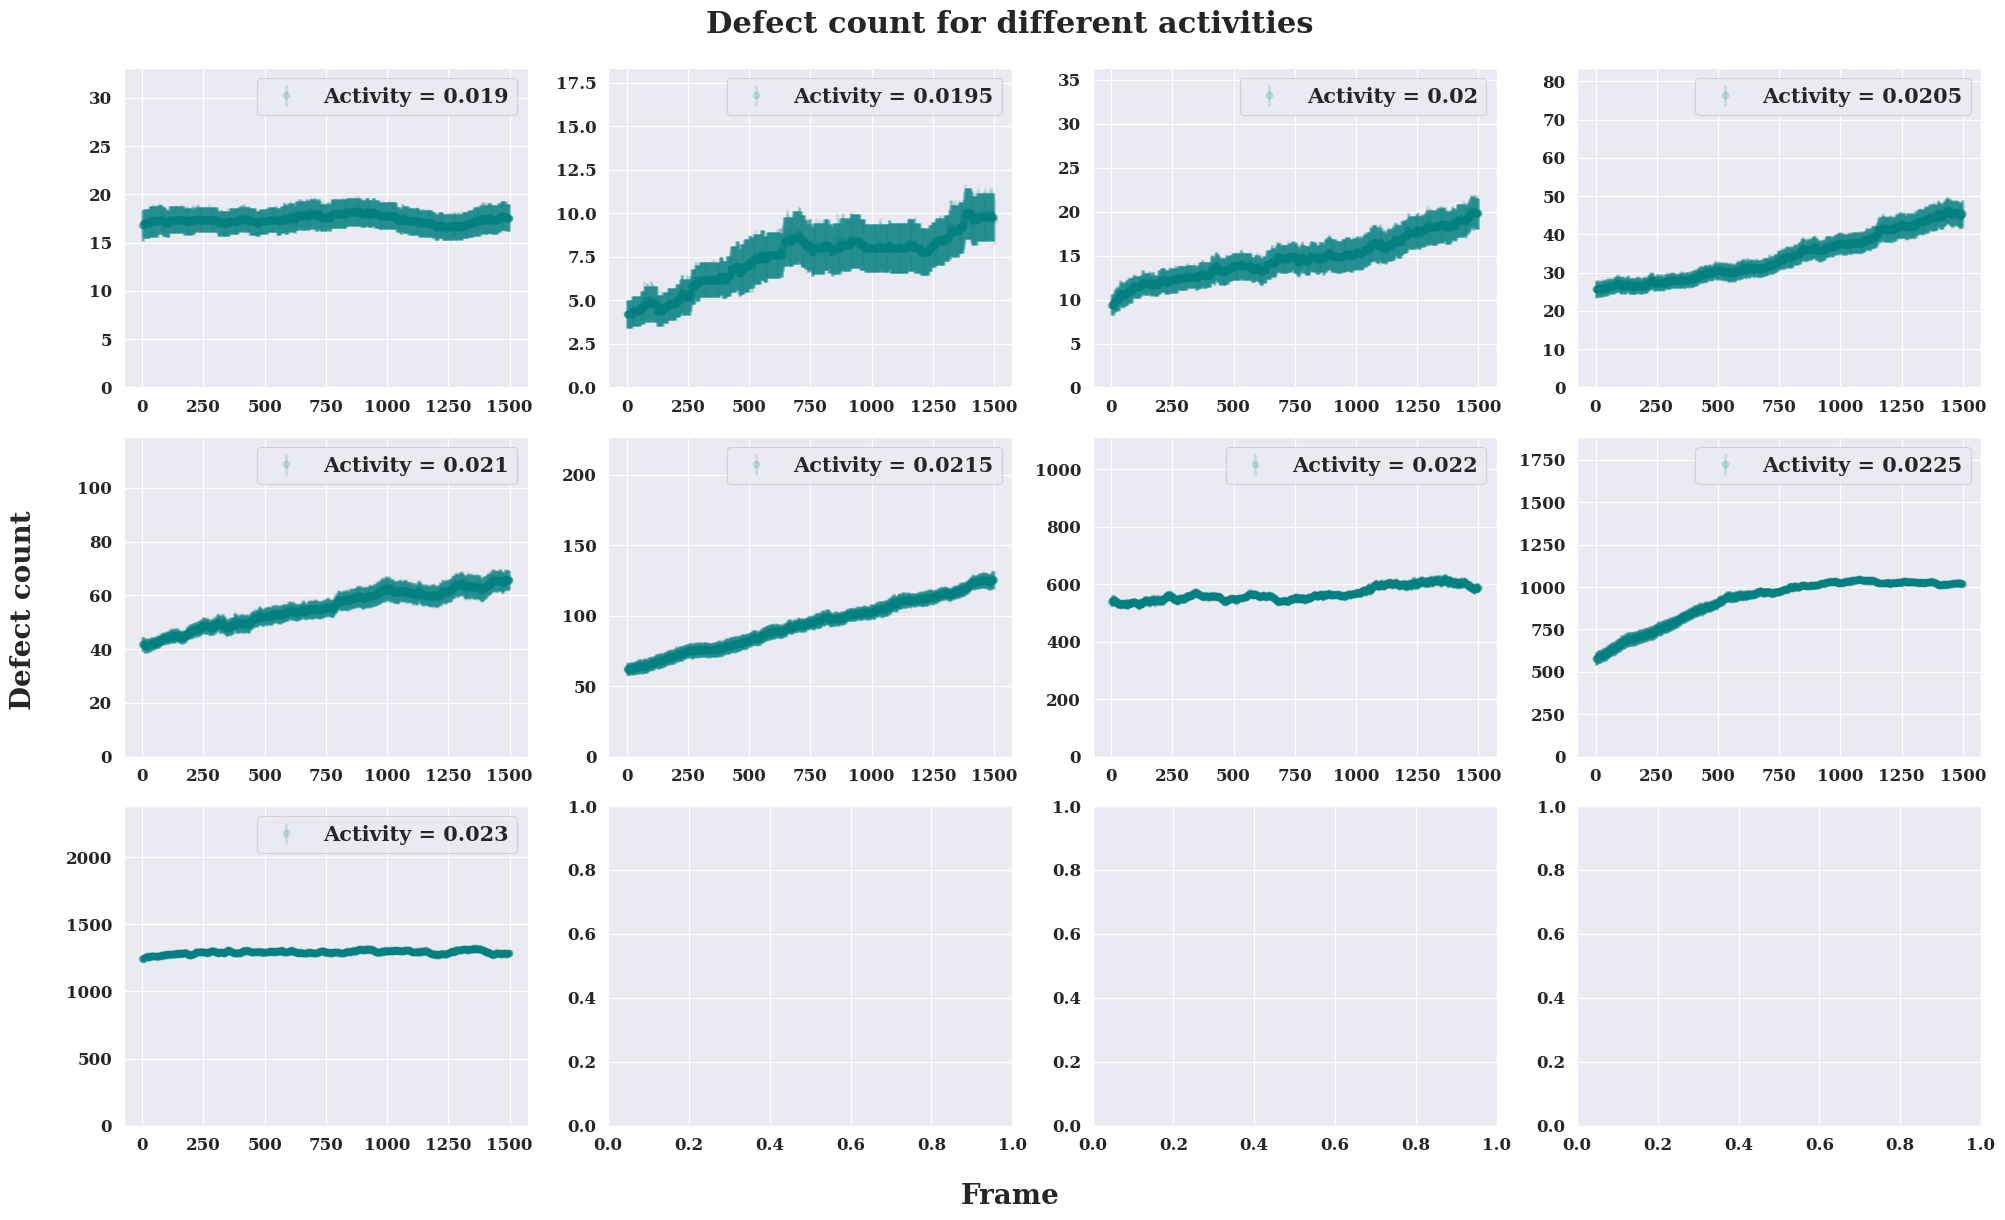

(<Figure size 2000x1200 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

In [94]:
ad.plot_defects_per_activity(Ndataset=3,Nfirst_frame=0)

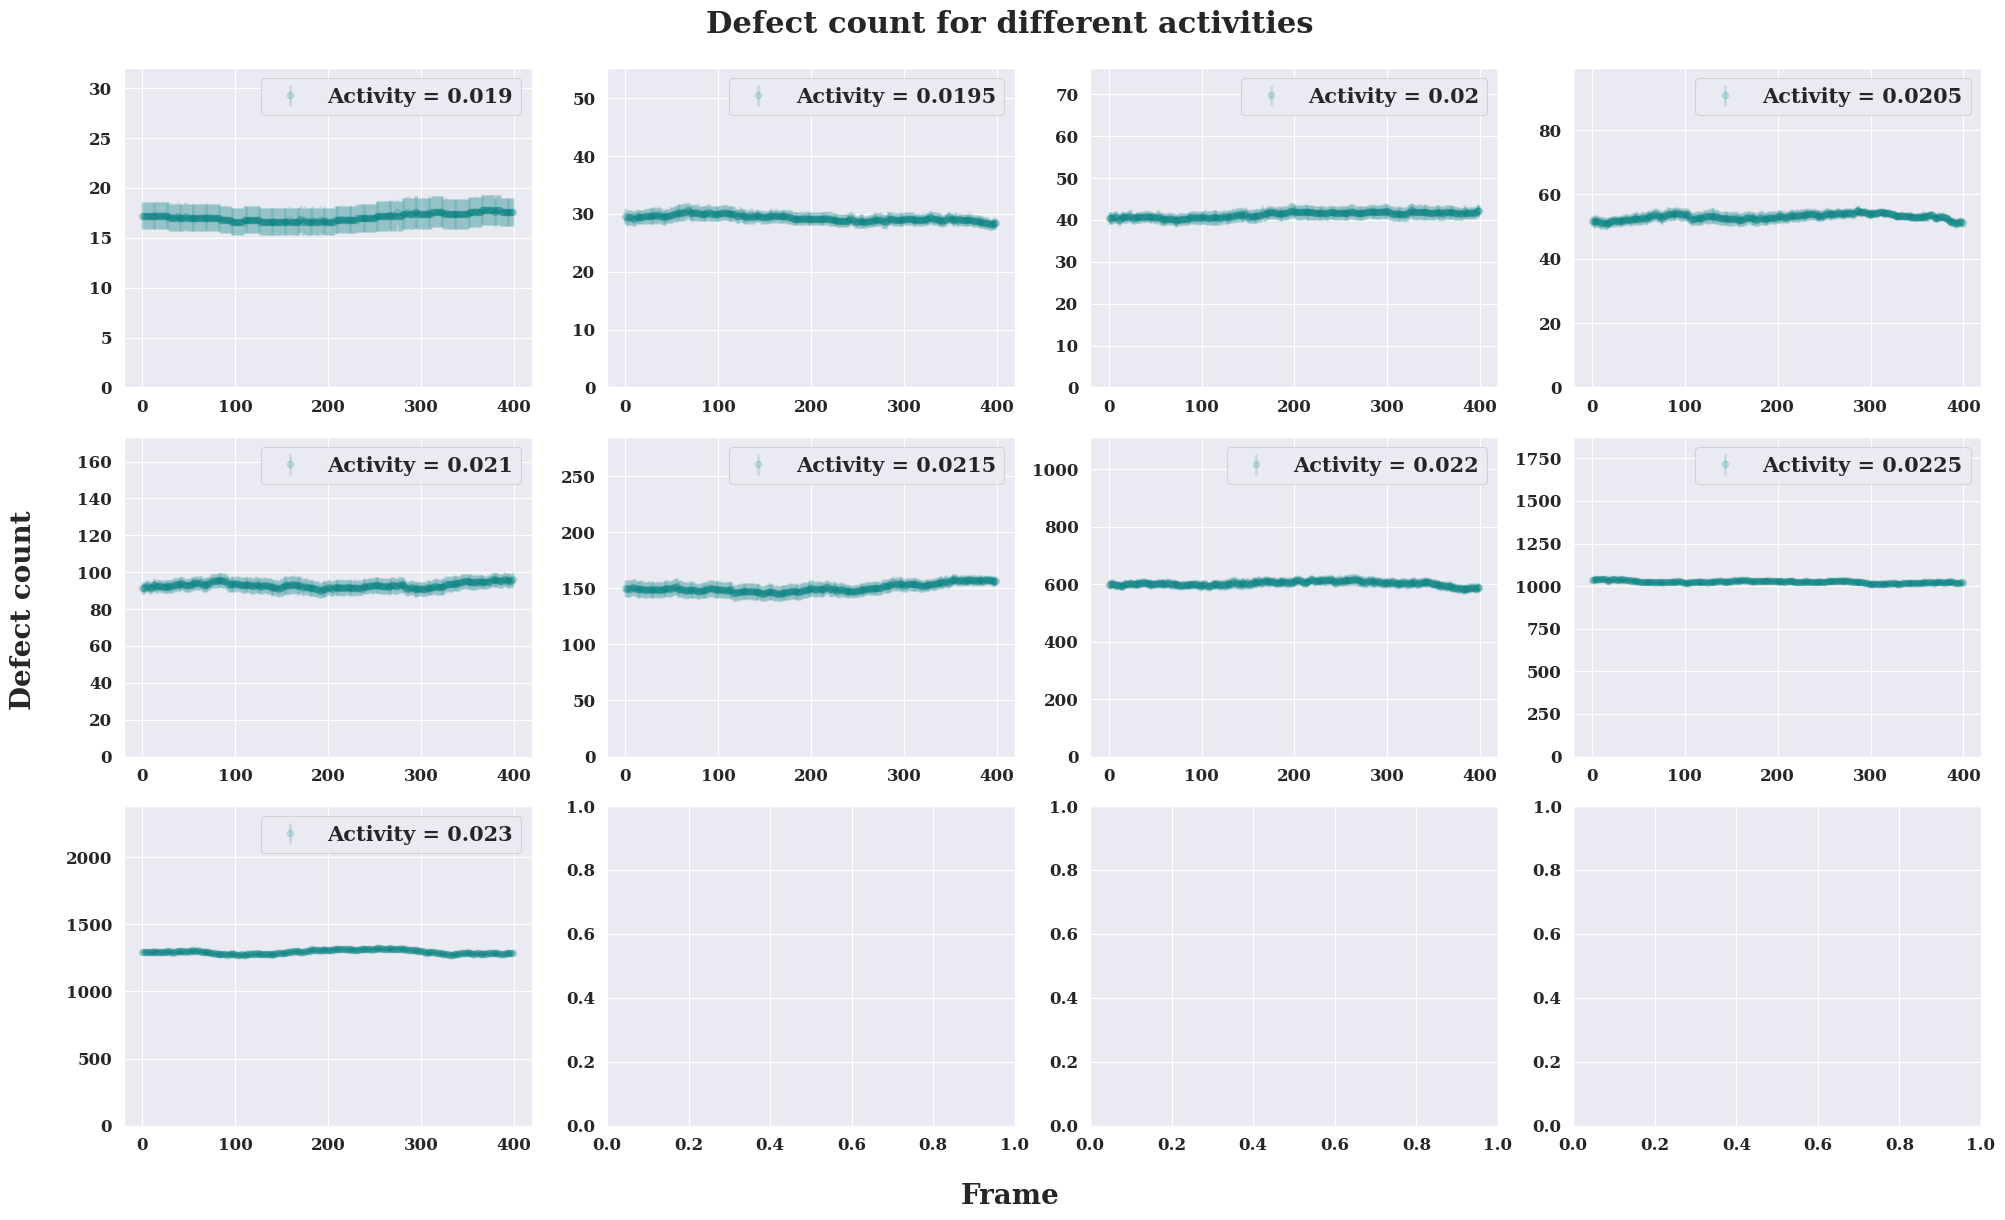

In [97]:
ad.plot_defects_per_activity(Ndataset=2, Nfirst_frame=1100, use_merged=False);


In [ ]:
ad.plot_defects_per_activity()

In [ ]:
fitp, statp = ad.analyze_hyperuniformity(fit_densities=True, save = False, \
                                         plot = True, use_merged = True,act_idx_bounds=[0,None], window_idx_bounds=[7, None]);
ad.plot_alpha_mean(use_density_fit=True, use_merged=True)

In [ ]:
ad.plot_alpha_mean(use_density_fit=True, use_merged=True)

In [ ]:
fig, ax = ad.plot_susceptibility(Nwindows_jump=5, use_merged=True, act_idx_bounds=[0,-1], window_idx_bounds=[0,None])
ax.set_xlim([0.01,0.095])

In [ ]:
ad.plot_alpha_mean(use_density_fit=True, use_merged=True)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
minn = 0
maxx = None
window_idx_bounds_list=[[minn, maxx], [minn, 20], [minn, 15], [20, maxx], [20, None], [10, maxx], [10, 20], [10, 25], [15,25], [15, maxx]]
for window in window_idx_bounds_list:
    fitp, statp = ad.analyze_hyperuniformity(fit_densities=True, save = False, plot = False, act_bounds=[8,-2], use_merged = True, window_idx_bounds=window);
    ax.plot(ad.act_list[0][8:-2], np.nanmean(fitp[:,:,0], axis = 0), '.-', label = f'{window[0]}:{window[1]}')
ax.set_ylim([-0.3,0.4])
ax.legend()